# Configuration

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)   # go one level up
print(os.getcwd())            # check

# pip install xflow-py
from xflow import ConfigManager, SqlProvider, PyTorchPipeline, show_model_info
from xflow.data import build_transforms_from_config
from xflow.utils import load_validated_config, save_image
import xflow.extensions.physics

import torch
import os
import tarfile
from datetime import datetime  
from config_utils import load_config
from utils import *


# Create experiment output directory  (timestamped)
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")  

experiment_name = "CAE"  # TM, SHL_DNN, U_Net, Pix2pix, ERN, CAE, SwinT, CAE_syth
folder_name = f"{experiment_name}-{timestamp}"  
config_manager = ConfigManager(load_config(f"{experiment_name}.yaml", 
                                           experiment_name=folder_name))
config = config_manager.get()
config_manager.add_files(config["extra_files"])

experiment_output_dir = config["paths"]["output"]
os.makedirs(experiment_output_dir, exist_ok=True)


# New structure, read the database table first, get files from it.
# Extract tar file if needed
if config['file_extract']:
    dataset_tar_file = os.path.join(config["paths"]["dataset"], config["data"]["dataset"])
    dataset_base_dir = os.path.dirname(dataset_tar_file)
    dataset_name = os.path.splitext(config["data"]["dataset"])[0]  # Remove .tar extension
    dataset_extracted_dir = os.path.join(dataset_base_dir, dataset_name)

    # Unzip tar file if not already extracted
    if not os.path.exists(dataset_extracted_dir):
        print(f"Extracting {dataset_tar_file}...")
        with tarfile.open(dataset_tar_file, 'r') as tar:
            tar.extractall(path=dataset_base_dir)
        print(f"Extracted to {dataset_extracted_dir}")
    else:
        print(f"Dataset already extracted at {dataset_extracted_dir}")

c:\Users\qiyuanxu\Documents\GitHub\fiber-image-reconstruction-comparison
[config_utils] Using machine profile: win-qiyuanxu


# Data preparation

In [2]:
# ==================== 
# Prepare Dataset
# ====================

def make_dataset(provider, transforms):
    return PyTorchPipeline(provider, transforms).to_memory_dataset(config["data"]["dataset_ops"])

train_dir = config["paths"]["training_set"]
# Create SqlProvider to query the database
db_path = f"{train_dir}/db/dataset_meta.db"
query = """
SELECT 
    image_path
FROM mmf_dataset_metadata 
WHERE batch IN (15)
--LIMIT 20
"""
train_provider = SqlProvider(
    sources={"connection": db_path, "sql": query}, output_config={'list': "image_path"}
)

test_dir = config["paths"]["test_set"]
# Create SqlProvider to query the database
db_path = f"{test_dir}/db/dataset_meta.db"
query = """
SELECT 
    image_path
FROM mmf_dataset_metadata 
WHERE batch IN (1, 7)
--LIMIT 20
"""
evaluation_provider = SqlProvider(
    sources={"connection": db_path, "sql": query}, output_config={'list': "image_path"}
)
val_provider, test_provider = evaluation_provider.split(ratio=config["data"]["val_test_split"], seed=config["seed"])

--------------------------------------------------------------------------------
Connected to SQLite database with 3 tables
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Connected to SQLite database with 3 tables
--------------------------------------------------------------------------------


In [ ]:

# For train dataset
config["data"]["transforms"]["torch"].insert(0, {
    "name": "add_parent_dir",
    "params": {
        "parent_dir": train_dir
    }
})
transforms = build_transforms_from_config(config["data"]["transforms"]["torch"])
train_dataset = make_dataset(train_provider, transforms)

# For test datasets
config["data"]["transforms"]["torch"][0]["params"]["parent_dir"] = test_dir
transforms = build_transforms_from_config(config["data"]["transforms"]["torch"])
val_dataset = make_dataset(val_provider, transforms)
test_dataset = make_dataset(test_provider, transforms)

print("Samples: ",len(train_provider),len(val_provider),len(test_provider))
print("Batch: ",len(train_dataset),len(val_dataset),len(test_dataset))

# save a sample from dataset for debugging
if experiment_name in REGRESSION:
    for left_parts, params, right_parts in test_dataset:
        print(f"Batch shapes: {left_parts.shape}, {right_parts.shape}")
        save_image(left_parts[0], config["paths"]["output"] + "/input.png")
        save_image(right_parts[0], config["paths"]["output"] + "/output.png")
        break
else:
    for index, sample in enumerate(test_dataset):  # test_dataset
        left_parts, right_parts = sample
        # batch will be a tuple: (right_halves, left_halves) due to split_width
        print(f"Batch shapes: {left_parts.shape}, {right_parts.shape}")
        if experiment_name in SAMPLE_FLATTENED:
            save_image(left_parts[0].reshape(config['data']['input_shape']), config["paths"]["output"] + f"/input_{index}.png")
            save_image(right_parts[0].reshape(config['data']['output_shape']), config["paths"]["output"] + f"/output_{index}.png")
        else:
            save_image(left_parts[0], config["paths"]["output"] + f"/input_{index}.png")
            save_image(right_parts[0], config["paths"]["output"] + f"/output_{index}.png")
        break

# Construct Model

In [ ]:
# ==================== 
# Construct Model
# ====================
if experiment_name == "CAE":
    from models.CAE import Autoencoder2D
    model = Autoencoder2D(
        in_channels=int(config['model']["in_channels"]),
        encoder=config['model']["encoder"],
        decoder=config['model']["decoder"],
        kernel_size=int(config['model']["kernel_size"]),
        apply_batchnorm=config['model']["apply_batchnorm"],
        apply_dropout=config['model']["apply_dropout"],
        final_activation=str(config['model']["final_activation"]),
    )
elif experiment_name == "TM":
    from models.TM import TransmissionMatrix
    model = TransmissionMatrix(
        input_height = config["data"]["input_shape"][0],
        input_width = config["data"]["input_shape"][1],
        output_height = config["data"]["output_shape"][0],
        output_width = config["data"]["output_shape"][1],
        initialization = "xavier",
    )
elif experiment_name == "SHL_DNN":
    from models.SHL_DNN import SHLNeuralNetwork
    model = SHLNeuralNetwork(
        input_size=config['data']['input_shape'][0] * config['data']['input_shape'][1],
        hidden_size=config['model']['hidden_size'], 
        output_size=config['data']['output_shape'][0] * config['data']['output_shape'][1],
        dropout_rate=config['model']['dropout_rate'],
    )
elif experiment_name == "U_Net":
    from models.U_Net import UNet
    model = UNet(
        in_channels=config["model"]["in_channels"],
        encoder=config["model"]["encoder"],
        decoder=config["model"]["decoder"],
        kernel_size=config["model"]["kernel_size"],
        apply_batchnorm=config["model"]["apply_batchnorm"],
        apply_dropout=config["model"]["apply_dropout"],
        out_channels=config["model"]["out_channels"],
        final_activation=config["model"]["final_activation"],
    )
elif experiment_name == "SwinT":
    from models.SwinT import SwinUNet, ReconLoss
    model = SwinUNet(
        img_size=config['model']['img_size'],
        in_chans=config['model']['in_chans'],
        out_chans=config['model']['out_chans'],
        embed_dim=config['model']['embed_dim'],
        depths=config['model']['depths'],
        num_heads=config['model']['num_heads'],
        window_size=config['model']['window_size'],
        patch_size=config['model']['patch_size'],
    )
elif experiment_name == "Pix2pix":
    from models.Pix2pix import Generator, Discriminator, Pix2PixLosses
    G = Generator(channels=config["model"]["channels"])
    D = Discriminator(channels=config["model"]["channels"])
    losses = Pix2PixLosses(lambda_l1=config["model"]["lambda_l1"])
    opt_g = torch.optim.Adam(G.parameters(), lr=config["training"]["learning_rate"], betas=config["training"]["betas"])
    opt_d = torch.optim.Adam(D.parameters(), lr=config["training"]["learning_rate"], betas=config["training"]["betas"])
elif experiment_name == "ERN":
    from models.ERN import EncoderRegressor
    model = EncoderRegressor(
            in_channels=config['model']['in_channels'],
            kernel_size=config['model']['kernel_size'],
            encoder=config['model']['encoder'],
            decoder=config['model']['decoder'],
            final_activation=config['model']['final_activation'],  
        )
elif experiment_name == "CAE_syth":
    from models.CAE import Autoencoder2D
    model = Autoencoder2D(
        in_channels=int(config['model']["in_channels"]),
        encoder=config['model']["encoder"],
        decoder=config['model']["decoder"],
        kernel_size=int(config['model']["kernel_size"]),
        apply_batchnorm=config['model']["apply_batchnorm"],
        apply_dropout=config['model']["apply_dropout"],
        final_activation=str(config['model']["final_activation"]),
    )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


if experiment_name == "Pix2pix":
    G = G.to(device)
    D = D.to(device)
    show_model_info(G)
    show_model_info(D)
elif experiment_name == "SwinT":
    from torch.optim.lr_scheduler import LambdaLR
    total_steps = config['training']['epochs'] * len(train_dataset)
    warmup_steps = int(config['training']['warmup_ratio'] * total_steps)
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        t = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        return 0.5 * (1.0 + math.cos(math.pi * t))

    model = model.to(device)
    criterion = ReconLoss(w_l1=config['training']['w_l1'], w_ssim=config['training']['w_ssim']) # Loss: L1 + 0.3*SSIM

    # Optimizer: AdamW with recommended params
    base_lr = 4e-4 if config['training']['batch_size'] >= 64 else 2e-4
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=base_lr, betas=config['training']['betas'],
        eps=config['training']['eps'], weight_decay=config['training']['weight_decay']
    )
    scheduler = LambdaLR(optimizer, lr_lambda)
    show_model_info(model)
else:
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['learning_rate'])
    show_model_info(model)

In [ ]:
# ==================== 
# Training
# ====================
from functools import partial

from xflow import TorchTrainer, TorchGANTrainer
from xflow.trainers import build_callbacks_from_config
from xflow.extensions.physics.beam import extract_beam_parameters

# 1) loss/optimizer
criterion = torch.nn.MSELoss()

# 2) callbacks (unchanged) + any custom wiring
callbacks = build_callbacks_from_config(
    config=config["callbacks"],
    framework=config["framework"],  
) # keep dataset closure for last callback, sequence hardcoded
callbacks[-1].set_dataset(test_dataset)

# Extract beam parameters closure (return as dict)
if experiment_name in SAMPLE_FLATTENED:
    extract_beam_parameters_dict = partial(extract_beam_parameters_flat, as_array=False)
    beam_param_metric = make_beam_param_metric(extract_beam_parameters_dict)
elif experiment_name in REGRESSION:   # e.g., "ERN"
    beam_param_metric = make_param_metric()
else:
    extract_beam_parameters_dict = partial(extract_beam_parameters, as_array=False)
    beam_param_metric = make_beam_param_metric(extract_beam_parameters_dict)

# 3) run training
if experiment_name in GAN:
    trainer = TorchGANTrainer(
        generator=G,
        discriminator=D,
        optimizer_g=opt_g,
        optimizer_d=opt_d,
        losses=losses,
        device=device,
        callbacks=callbacks,
        output_dir=config["paths"]["output"],
        data_pipeline=train_dataset,
        val_metrics=[beam_param_metric],
    )
else:
    trainer = TorchTrainer(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        callbacks=callbacks,
        output_dir=config["paths"]["output"],
        data_pipeline=train_dataset,
        val_metrics=[beam_param_metric],
        scheduler= scheduler if experiment_name == "SwinT" else None, 
        scheduler_step_per_batch=True,
    )

history = trainer.fit(
    train_loader=train_dataset, 
    val_loader=val_dataset,
    epochs=config['training']['epochs'],
)

# 4) save results
trainer.save_history(f"{config['paths']['output']}/history.json")
trainer.save_model(config["paths"]["output"])  # uses model.save_model(...) if available
config_manager.save(output_dir=config["paths"]["output"], config_filename=config["name"])

print("Training ALL complete.")

# Data Analysis

In [3]:
import numpy as np
import cv2
from tqdm import tqdm
from xflow.data.transform import add_parent_dir, split_width

def compute_intensity_centers(image_paths):
    """
    Given a list of image file paths, compute intensity-weighted
    (x, y) centers for each image and return a list of (x, y) tuples.
    """
    centers = []

    for img_path in tqdm(image_paths, desc="Processing images"):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img, _ = split_width(img)

        # 1D projections along x and y
        x_hist = img.sum(axis=0)  # width
        y_hist = img.sum(axis=1)  # height

        x_idx = np.arange(img.shape[1])
        y_idx = np.arange(img.shape[0])

        x_sum = x_hist.sum()
        y_sum = y_hist.sum()

        x_center = (x_hist * x_idx).sum() / x_sum if x_sum > 0 else np.nan
        y_center = (y_hist * y_idx).sum() / y_sum if y_sum > 0 else np.nan

        centers.append((x_center, y_center))

    return centers

center_points_testset = compute_intensity_centers([add_parent_dir(x, config["paths"]["test_set"]) for x in evaluation_provider()] )
center_points_trainset = compute_intensity_centers([add_parent_dir(x, config["paths"]["training_set"]) for x in train_provider()] )

Processing images: 100%|██████████| 4776/4776 [03:06<00:00, 25.66it/s]


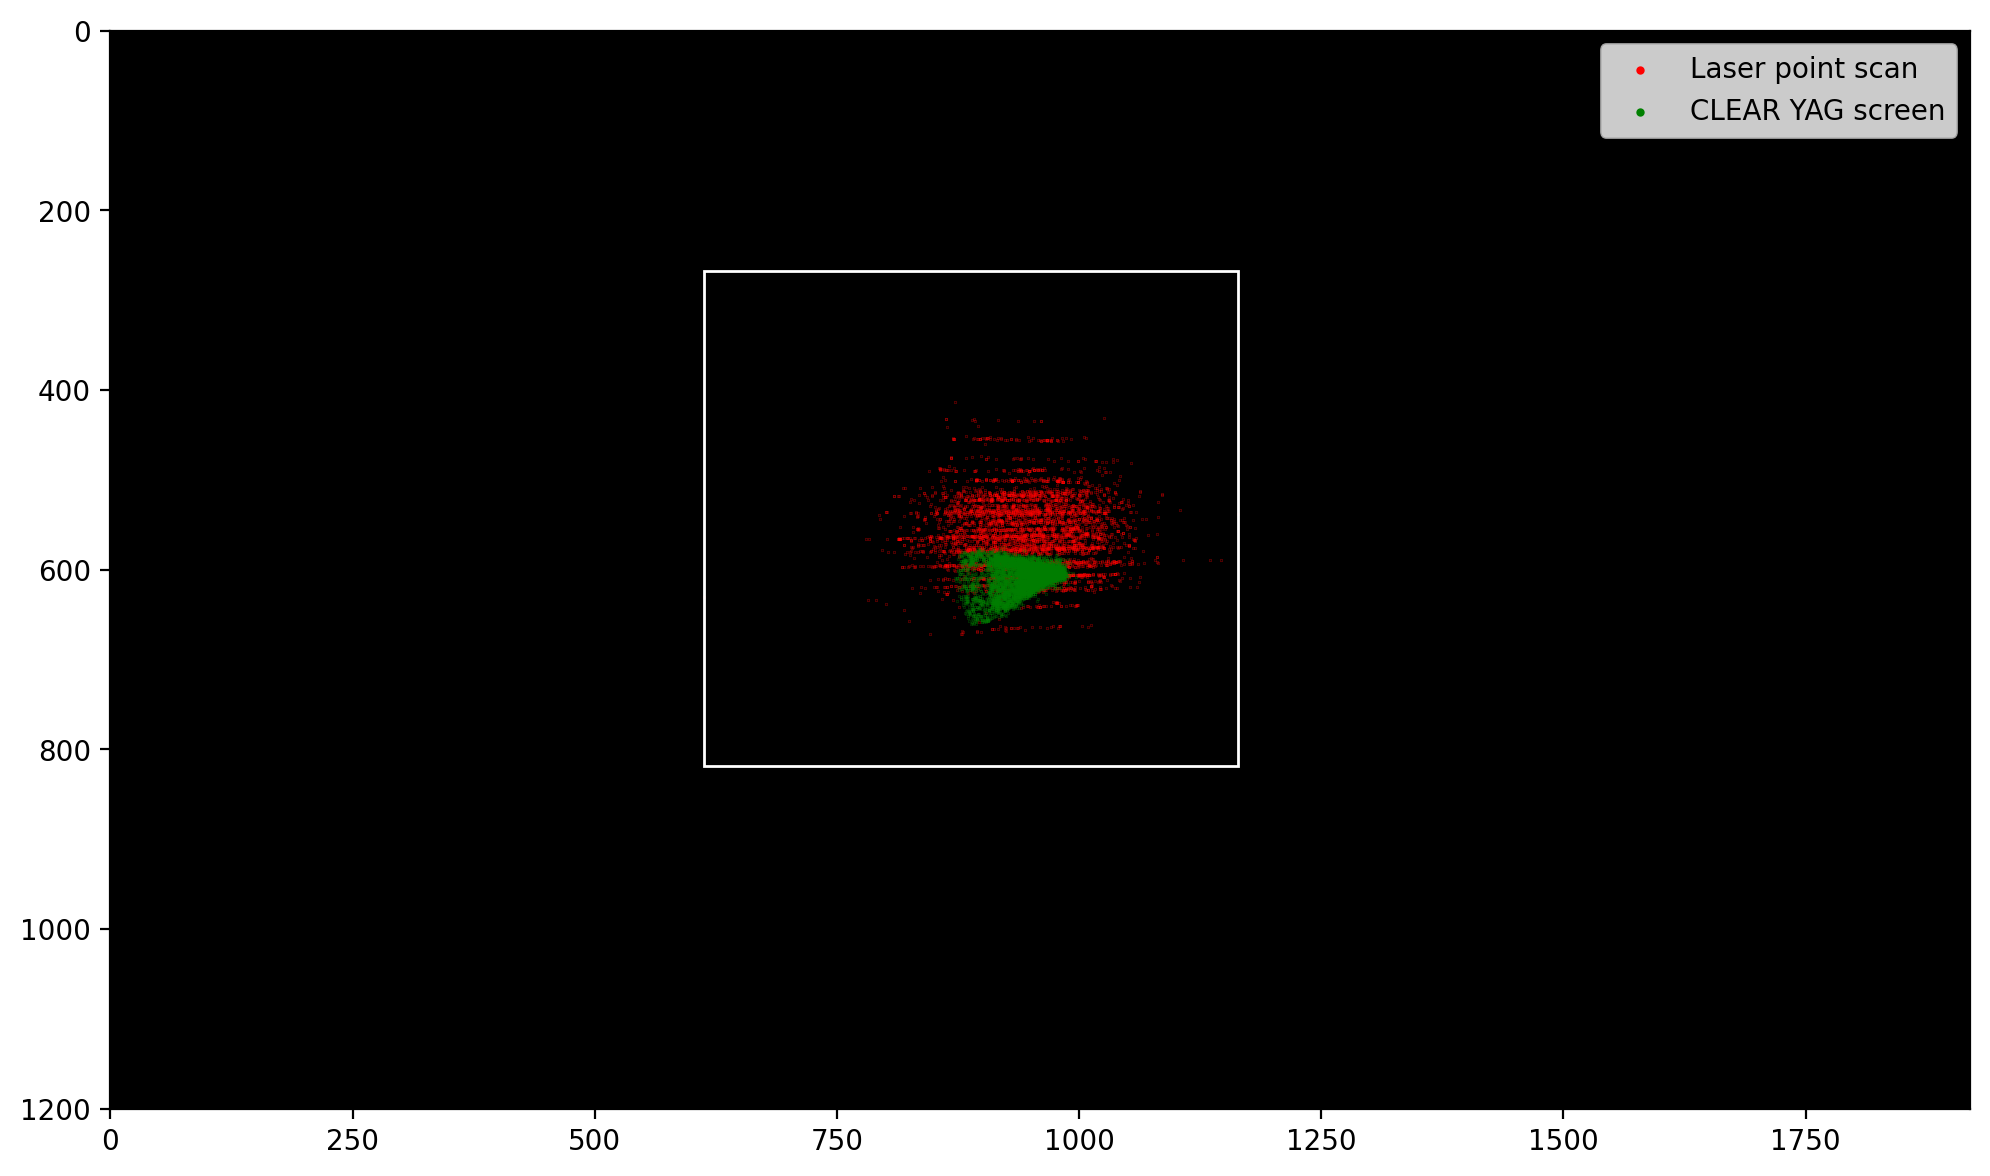

Fitted square top-left: (np.float64(612.7519564524841), np.float64(267.160217541208)), bottom-right: (np.float64(1164.1830297571391), np.float64(818.591290845863))


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_points_and_fit_square(
    points1,
    points2=None,
    image_size=(1920, 1200),
    figsize=(10, 6),
    dpi=150,
    point_size=5,
    label1="Set 1",
    label2="Set 2",
):
    width, height = image_size

    # collect all valid points
    all_points = []
    if points1 is not None:
        all_points.extend(points1)
    if points2 is not None:
        all_points.extend(points2)

    all_points = [
        (x, y)
        for x, y in all_points
        if x is not None and y is not None and not (np.isnan(x) or np.isnan(y))
    ]

    if not all_points:
        return None, None

    xs = np.array([p[0] for p in all_points], dtype=float)
    ys = np.array([p[1] for p in all_points], dtype=float)

    min_x, max_x = xs.min(), xs.max()
    min_y, max_y = ys.min(), ys.max()

    width_bb = max_x - min_x
    height_bb = max_y - min_y
    side = max(width_bb, height_bb)

    cx = (min_x + max_x) / 2.0
    cy = (min_y + max_y) / 2.0
    half = side / 2.0

    tl_x = cx - half
    tl_y = cy - half
    br_x = cx + half
    br_y = cy + half

    top_left = (tl_x, tl_y)
    bottom_right = (br_x, br_y)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)  # invert y to image coords
    ax.set_facecolor("black")

    handles = []

    if points1:
        xs1 = [p[0] for p in points1]
        ys1 = [p[1] for p in points1]
        h1 = ax.scatter(xs1, ys1, s=point_size, c="red", label=label1, marker="o")
        handles.append(h1)

    if points2:
        xs2 = [p[0] for p in points2]
        ys2 = [p[1] for p in points2]
        h2 = ax.scatter(xs2, ys2, s=point_size, c="green", label=label2, marker="o")
        handles.append(h2)

    rect = Rectangle(
        (tl_x, tl_y),
        br_x - tl_x,
        br_y - tl_y,
        fill=False,
        edgecolor="white",
        linewidth=1,
    )
    ax.add_patch(rect)

    if handles:
        # markerscale multiplies the original marker size
        ax.legend(markerscale=20)

    plt.show()
    return top_left, bottom_right



tl, br = plot_points_and_fit_square(
    center_points_trainset,
    center_points_testset,
    image_size=(1920, 1200),
    figsize=(12, 7),
    point_size=0.01,
    label1="Laser point scan",
    label2="CLEAR YAG screen",
    dpi=200,
)

print(f"Fitted square top-left: {tl}, bottom-right: {br}")

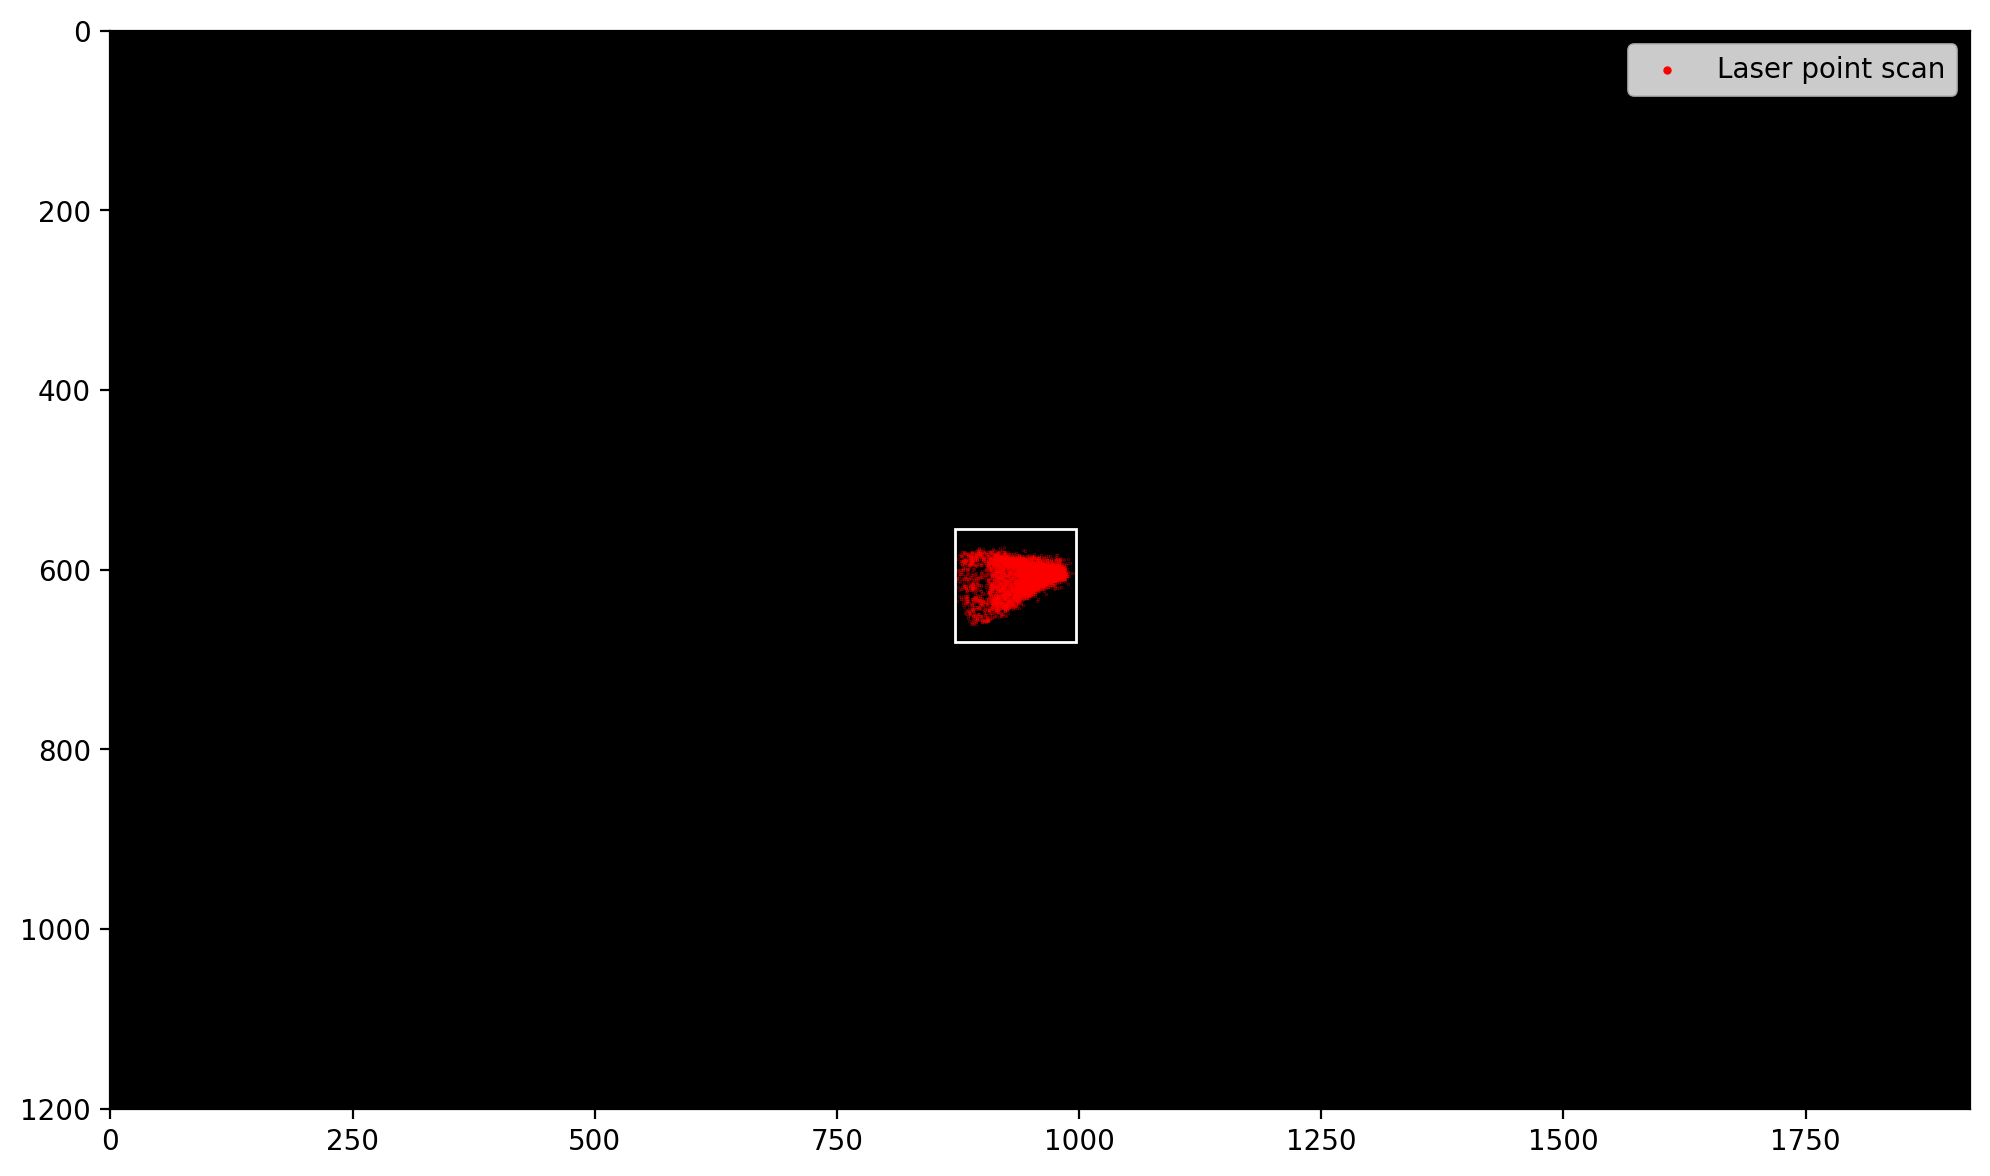

((np.float64(871.4622431214306), np.float64(554.9158578667382)),
 (np.float64(997.035951897548), np.float64(680.4895666428556)))

In [6]:
plot_points_and_fit_square(
    center_points_testset,
    image_size=(1920, 1200),
    figsize=(12, 7),
    point_size=0.01,
    label1="Laser point scan",
    label2="CLEAR YAG screen",
    dpi=200,
)